# Here emotion prediction was done using multi tasking of arousal & valence.As arousal & valence are corelated ,it provide a better modelling.

In [1]:

#Loading The Dataset

import os
import fnmatch
import numpy as np

from sys     import argv
#from sklearn import svm

from load_features     import load_all
#from calc_scores       import calc_scores
#from write_predictions import write_predictions

# Set folders here
path_test_predictions = "D:/AVEC_17_Emotion_Sub-Challenge/result/"
b_test_available      = False  # If the test labels are not available, the predictions on test are written into the folder 'path_test_predictions'

# Folders wi o_features = "E:/AVEC_17_Emotion_Sub-Challenge/audio_features_xbow_6s/"
path_audio_features = "D:/AVEC_17_Emotion_Sub-Challenge/audio_features_xbow_6s/"
path_video_features = "D:/AVEC_17_Emotion_Sub-Challenge/video_features_xbow_6s/"
path_text_features  = "D:/AVEC_17_Emotion_Sub-Challenge/text_features_xbow_6s/"
path_labels         = "D:/AVEC_17_Emotion_Sub-Challenge/labels/"

sr_labels = 0.1

delay = 0.60
b_audio = True
b_video = True
b_text  = True
rise = 0.20


for k in range(1):
    print("Inside run_baseline.py")
    print(len(argv))
#if len(argv)>1:
     #delay = float(argv[1])
#if len(argv)>2:    
    #b_audio = bool(int(argv[2]))
    #b_video = bool(int(argv[3]))
    #b_text  = bool(int(argv[4]))

    print("argv")
    print(argv)
    print("delay")
    print(delay)

    path_features = []
    if b_audio:
        path_features.append( path_audio_features )
    if b_video:
        path_features.append( path_video_features )
    if b_text:
        path_features.append( path_text_features )
        

    if not b_test_available and not os.path.exists(path_test_predictions):
        os.mkdir(path_test_predictions)

# Compensate the delay (quick solution)
    shift = int(np.round(delay/sr_labels))
    shift = np.ones(len(path_features),dtype=int)*shift



    files_train = fnmatch.filter(os.listdir(path_features[0]), "Train*")  # Filenames are the same for audio, video, text & labels
    files_devel = fnmatch.filter(os.listdir(path_features[0]), "Devel*")
    files_test  = fnmatch.filter(os.listdir(path_features[0]), "Test*")



    print("i am going")
    print(files_train)

# Load features and labels
    Train   = load_all( files_train, path_features, shift )
    Devel   = load_all( files_devel, path_features, shift )
    Train_L = load_all( files_train, [ path_labels ] )  # Labels are not shifted
    Devel_L = load_all( files_devel, [ path_labels ] )


Inside run_baseline.py
3
argv
['c:\\users\\abhijit\\anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\abhijit\\AppData\\Roaming\\jupyter\\runtime\\kernel-8ab98811-4750-4eb3-818e-b784556a051b.json']
delay
0.6
i am going
['Train_01.csv', 'Train_02.csv', 'Train_03.csv', 'Train_04.csv', 'Train_05.csv', 'Train_06.csv', 'Train_07.csv', 'Train_08.csv', 'Train_09.csv', 'Train_10.csv', 'Train_11.csv', 'Train_12.csv', 'Train_13.csv', 'Train_14.csv', 'Train_15.csv', 'Train_16.csv', 'Train_17.csv', 'Train_18.csv', 'Train_19.csv', 'Train_20.csv', 'Train_21.csv', 'Train_22.csv', 'Train_23.csv', 'Train_24.csv', 'Train_25.csv', 'Train_26.csv', 'Train_27.csv', 'Train_28.csv', 'Train_29.csv', 'Train_30.csv', 'Train_31.csv', 'Train_32.csv', 'Train_33.csv', 'Train_34.csv']


# Windowing the timesteps

In [2]:
#windowing the dataset

def create_data(dataset,look_back=1):
    dataX = []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:i+look_back,:]
        dataX.append(a)
    return np.array(dataX)

In [3]:
look_back = 8
TrainX = create_data(Train,look_back)

In [4]:
TrainX.shape

(56085, 8, 4521)

In [5]:
Train_LA = Train_L[look_back-1:,0]

In [6]:
Train_LV = Train_L[look_back-1:,1]



In [8]:


look_back = 8
Devel_X = create_data(Devel,look_back)
Devel_LA = Devel_L[look_back-1:,0]

In [9]:
Devel_LV = Devel_L[look_back-1:,1]

# The Trainer

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import TimeDistributed,Input
from keras.layers import Bidirectional
from keras.models import Model
from keras.layers.merge import concatenate
from keras import regularizers


    
inputs = Input(shape = (look_back,4521))
s = inputs
s1 = LSTM(400,input_shape=(look_back,4521),go_backwards=True,return_sequences= True, dropout = .7,bias_initializer = 'ones')(s)
s2 = LSTM(200,input_shape=(look_back,4521),go_backwards=True,return_sequences=True,dropout = .6,bias_initializer = 'ones')(s1)
s3 = LSTM(200,input_shape=(look_back,4521),go_backwards=True,return_sequences=True,dropout = .5)(s2)
s4 = LSTM(200,input_shape=(look_back,4521),go_backwards=True,return_sequences=True,dropout = .5)(s3)



s5 = LSTM(200,input_shape=(look_back,4521),go_backwards=True,dropout = .7)(s4)
s6 = LSTM(200,input_shape=(look_back,4521),go_backwards=True,dropout = .7)(s4)

output_1 = Dense(1,bias_initializer = 'ones')(s5)
output_2 = Dense(1,bias_initializer = 'ones')(s6)

model = Model(inputs=[inputs], outputs=[output_1,output_2])
model.compile(optimizer='adam', loss='mse')
model.summary()


    
    

NameError: name 'look_back' is not defined

# Fitting the data

In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('thesis_mult_task.h5', verbose=1, save_best_only=True)

results = model.fit(TrainX,[Train_LA,Train_LV],epochs = 4,validation_split=0.2,callbacks=[earlystopper, checkpointer])


c:\users\abhijit\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'model' is not defined

In [136]:
from keras.models import Model, load_model

model = load_model('thesis_mult_task.h5')
predA,predV = model.predict(Devel_X)

# Calculating CCC,PCC,RMSE

In [140]:
#calculating CCC PCC RMSE
predA = predA.reshape(22720,)
x = predA

#x = a
y = Devel_L[look_back-1:,1]
x_mean = np.nanmean(x)
y_mean = np.nanmean(y)

#np.nanmean((x - x_mean) * (y - y_mean)) 
covariance = np.nanmean((x-x_mean)*(y-y_mean))
    
x_var = 1.0 / (len(x)-1) * np.nansum((x-x_mean)**2) # Make it consistent with Matlab's nanvar (division by len(x)-1, not len(x)))
y_var = 1.0 / (len(y)-1) * np.nansum((y-y_mean)**2)
    
CCC = (2*covariance) / (x_var + y_var + (x_mean-y_mean)**2)

x_std = np.sqrt(x_var)
y_std = np.sqrt(y_var)
PCC = covariance / (x_std * y_std)
    
RMSE = np.sqrt(np.nanmean((x - y)**2))

In [141]:
CCC

0.45762514985937663

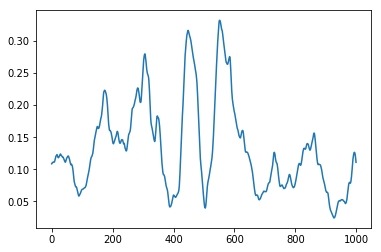

In [142]:
import matplotlib.pyplot as plt
plt.plot(predA[500:1500])
plt.show()

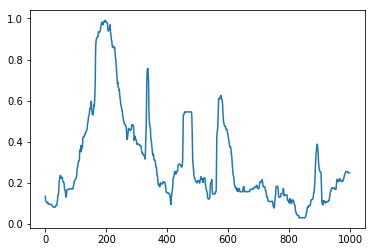

In [65]:
plt.plot(y[500:1500,])
plt.show()